In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


In [3]:
from IPython.display import Image, display

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")


/Users/rishitkamboj/College/langschain course /.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"


#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

# MY EXAMPLES



## Using in-built messages functions, A graph which only keeps the 3 most recent messages and deletes the rest

In [6]:
# Cell 1: Imports
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage


In [7]:
# Cell 2: Filter Node - keep only last 3 messages
def filter_messages(state: MessagesState):
    # Remove all except the last 3 messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-3]]
    return {"messages": delete_messages}


In [8]:

# Cell 3: Chat Node (dummy, just passes through, here for structure)
def chat_model_node(state: MessagesState):
    # In practice this could add new messages with add_messages, here passthrough
    return {"messages": state["messages"]}



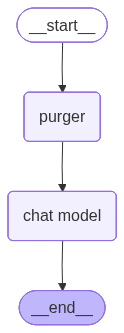

In [9]:
# Cell 4: Build graph
builder = StateGraph(MessagesState)
builder.add_node("purger", filter_messages)
builder.add_node("chat model", chat_model_node)
builder.add_edge(START, "purger")
builder.add_edge("purger", "chat model")
builder.add_edge("chat model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


### testing with an example

In [10]:
# Cell 5: Example with more than 3 messages
msgs = [
    HumanMessage(content="Hi", id="1"),
    AIMessage(content="Hello! How can I help?", id="2"),
    HumanMessage(content="What's the weather?", id="3"),
    AIMessage(content="It's sunny.", id="4"),
    HumanMessage(content="Thanks!", id="5"),
]
# The result should keep only messages with ids "3", "4", "5"
result = graph.invoke({"messages": msgs})
for m in result["messages"] :
    m.pretty_print() 

================================ Human Message =================================

What's the weather?
================================== Ai Message ==================================

It's sunny.
================================ Human Message =================================

Thanks!


### testing it with another example

In [11]:

msgs = [
    HumanMessage(content="Who is Luke Skywalker?", id="1"),
    AIMessage(content="Luke Skywalker is a legendary Jedi Knight.", id="2"),
    HumanMessage(content="Who is his father?", id="3"),
    AIMessage(content="His father is Anakin Skywalker, also known as Darth Vader.", id="4"),
    HumanMessage(content="Who built C-3PO?", id="5"),
    AIMessage(content="C-3PO was built by Anakin Skywalker.", id="6"),
    HumanMessage(content="What's the name of Han Solo's ship?", id="7"),
    AIMessage(content="Han Solo's ship is called the Millennium Falcon.", id="8"),
]

result = graph.invoke({"messages": msgs})
for m in result["messages"] :
    m.pretty_print()


================================== Ai Message ==================================

C-3PO was built by Anakin Skywalker.
================================ Human Message =================================

What's the name of Han Solo's ship?
================================== Ai Message ==================================

Han Solo's ship is called the Millennium Falcon.


### another example

In [12]:
msgs = [
    HumanMessage(content="Who won the 2021 Monaco Grand Prix?", id="1"),
    AIMessage(content="Max Verstappen won the 2021 Monaco Grand Prix.", id="2"),
    HumanMessage(content="What's the fastest lap ever at Monza?", id="3"),
    AIMessage(content="Lewis Hamilton set the lap record at Monza in 2020.", id="4"),
    HumanMessage(content="Which team has the most Constructors’ Championships?", id="5"),
    AIMessage(content="Ferrari holds the record for the most Constructors’ Championships.", id="6"),
    HumanMessage(content="Who is Charles Leclerc's teammate in 2023?", id="7"),
    AIMessage(content="Carlos Sainz Jr. is Leclerc's teammate in 2023.", id="8"),
]
result = graph.invoke({"messages": msgs})
for m in result["messages"] :
    m.pretty_print()


================================== Ai Message ==================================

Ferrari holds the record for the most Constructors’ Championships.
================================ Human Message =================================

Who is Charles Leclerc's teammate in 2023?
================================== Ai Message ==================================

Carlos Sainz Jr. is Leclerc's teammate in 2023.


## Filtering messages which passes the last 2 messages to the model but preserves all of them

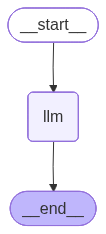

In [13]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage

# Node to filter last 2 messages
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-2:])]}


builder = StateGraph(MessagesState)
builder.add_node("llm", chat_model_node)
builder.add_edge(START, "llm")
builder.add_edge("llm", END)
graph = builder.compile()

# Example conversation
msgs = [
    HumanMessage(content="What year was the first F1 race?", id="1"),
    AIMessage(content="The first Formula 1 race was in 1950.", id="2"),
    HumanMessage(content="Who won the most Monaco GPs?", id="3"),
    AIMessage(content="Ayrton Senna has won Monaco the most times.", id="4"),
    HumanMessage(content="Which team is the most successful?", id="5"),
    AIMessage(content="Ferrari is the most successful team in F1 history.", id="6"),
]

display(Image(graph.get_graph().draw_mermaid_png()))



### we can see in langsmith portal that only the last 2 msges were provided as inputs : 

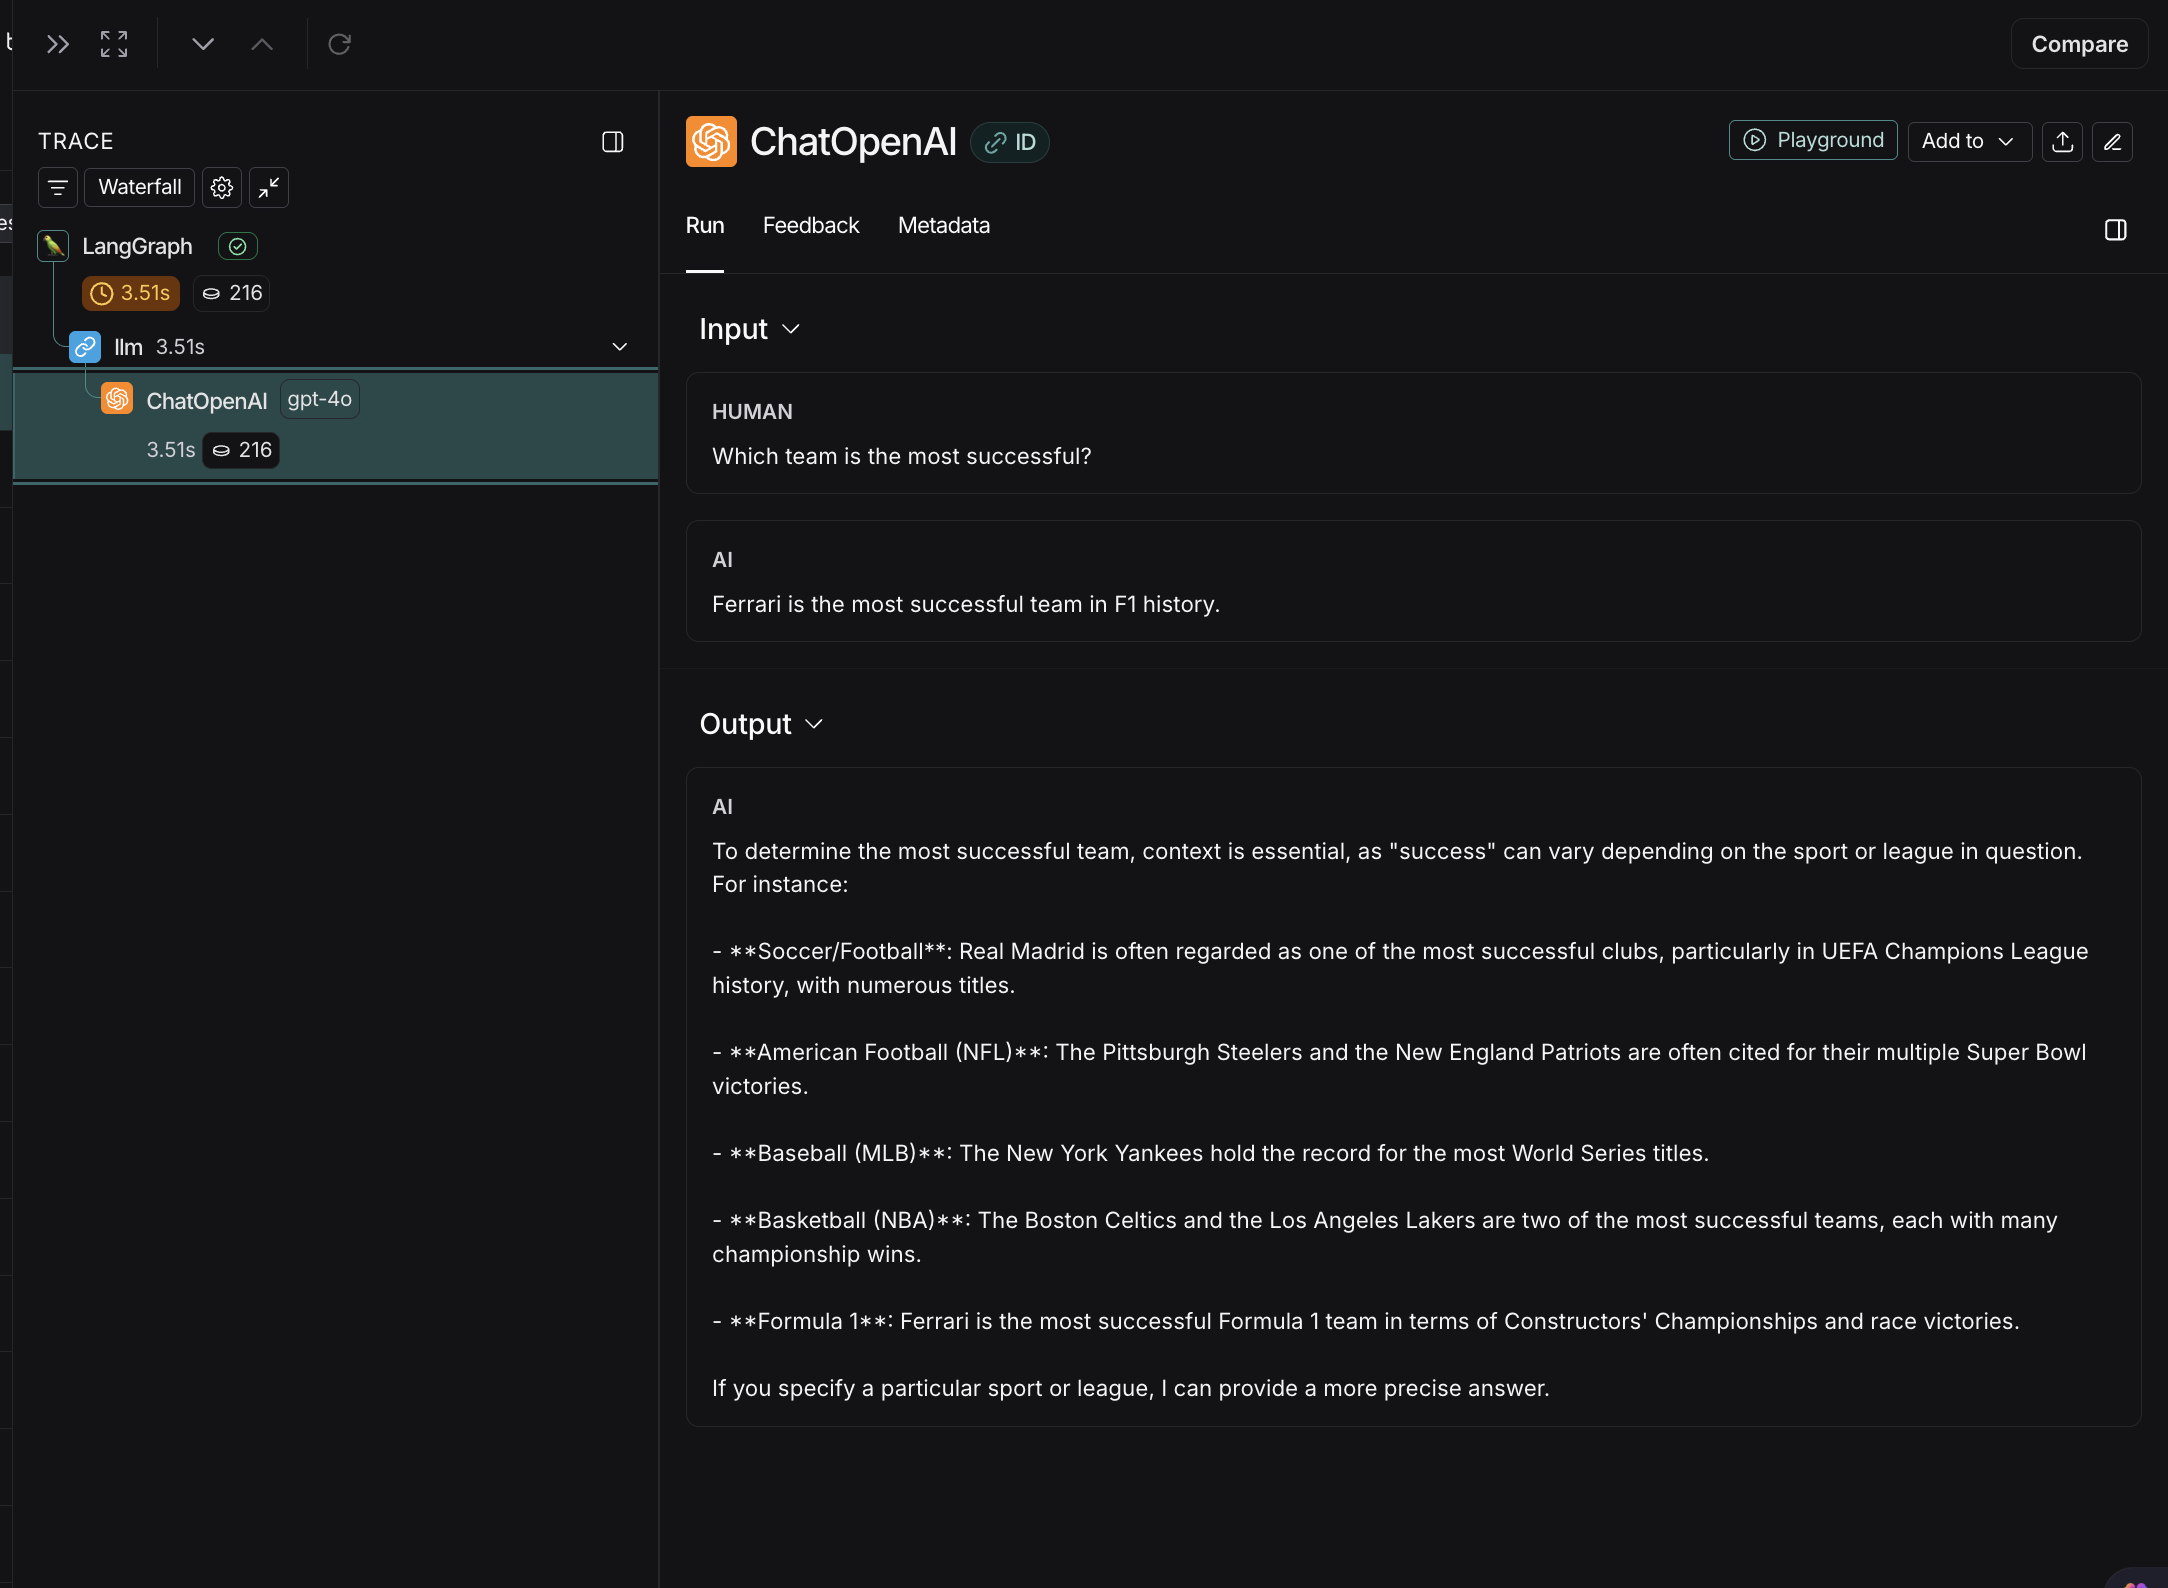

### we can also see all the messages are preserved 

In [14]:
result = graph.invoke({"messages": msgs})
for m in result["messages"] :
    m.pretty_print()

================================ Human Message =================================

What year was the first F1 race?
================================== Ai Message ==================================

The first Formula 1 race was in 1950.
================================ Human Message =================================

Who won the most Monaco GPs?
================================== Ai Message ==================================

Ayrton Senna has won Monaco the most times.
================================ Human Message =================================

Which team is the most successful?
================================== Ai Message ==================================

Ferrari is the most successful team in F1 history.
================================== Ai Message ==================================

When discussing the most successful sports teams, it often depends on the specific criteria and the sport being considered. For example:

- **Football (Soccer):** Real Madrid is often cited as the

## Made a graph which automatically trims inputs greater than 250 tokens

In [15]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, trim_messages
from langchain_groq import ChatGroq

# The model whose token counter we'll use
GROQ_API_KEY = "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" 


llm = ChatGroq(
    model="llama-3.3-70b-versatile", 
    api_key=GROQ_API_KEY
)

def chat_model_node(state: MessagesState):
    # Only pass as many messages as fit in 250 tokens, keeping the most recent ("last" strategy)
    trimmed = trim_messages(
        state["messages"],
        max_tokens=250,
        strategy="last",
        token_counter=llm
    )
    return {"messages": [llm.invoke(msgs)]}

builder = StateGraph(MessagesState)
builder.add_node("trimmer", chat_model_node)
builder.add_edge(START, "trimmer")
builder.add_edge("trimmer", END)
graph = builder.compile()

# Example conversation
msgs = [
    HumanMessage(content="Hello, can you help me with something commplicated involving math and science?", id="1"),
    AIMessage(content="Absolutely! Please tell me your question or the topic you're exploring.", id="2"),
    HumanMessage(content="Can you explain quantum entanglement to a beginner and also what 'spin' means in this context?", id="3"),
    AIMessage(content="Quantum entanglement means two particles are linked... 'Spin' is a type of particle property...", id="4"),
    HumanMessage(content="Thanks, that was helpful, but what about applications of this phenomenon?", id="5"),
    AIMessage(content="Applications include quantum computing, secure communication, and more.", id="6"),
]


result = graph.invoke({"messages": msgs})
for m in result["messages"]:
    print(f"{type(m).__name__}: {m.content}")


HumanMessage: Hello, can you help me with something commplicated involving math and science?
AIMessage: Absolutely! Please tell me your question or the topic you're exploring.
HumanMessage: Can you explain quantum entanglement to a beginner and also what 'spin' means in this context?
AIMessage: Quantum entanglement means two particles are linked... 'Spin' is a type of particle property...
HumanMessage: Thanks, that was helpful, but what about applications of this phenomenon?
AIMessage: Applications include quantum computing, secure communication, and more.
AIMessage:  Quantum entanglement is a fundamental concept in quantum mechanics, and its unique properties make it a fascinating area of research with potential practical applications.

Some examples of applications include:

1. **Quantum Computing**: Quantum entanglement is a key component in the development of quantum computers. By harnessing entangled particles, quantum computers can perform calculations exponentially faster than c

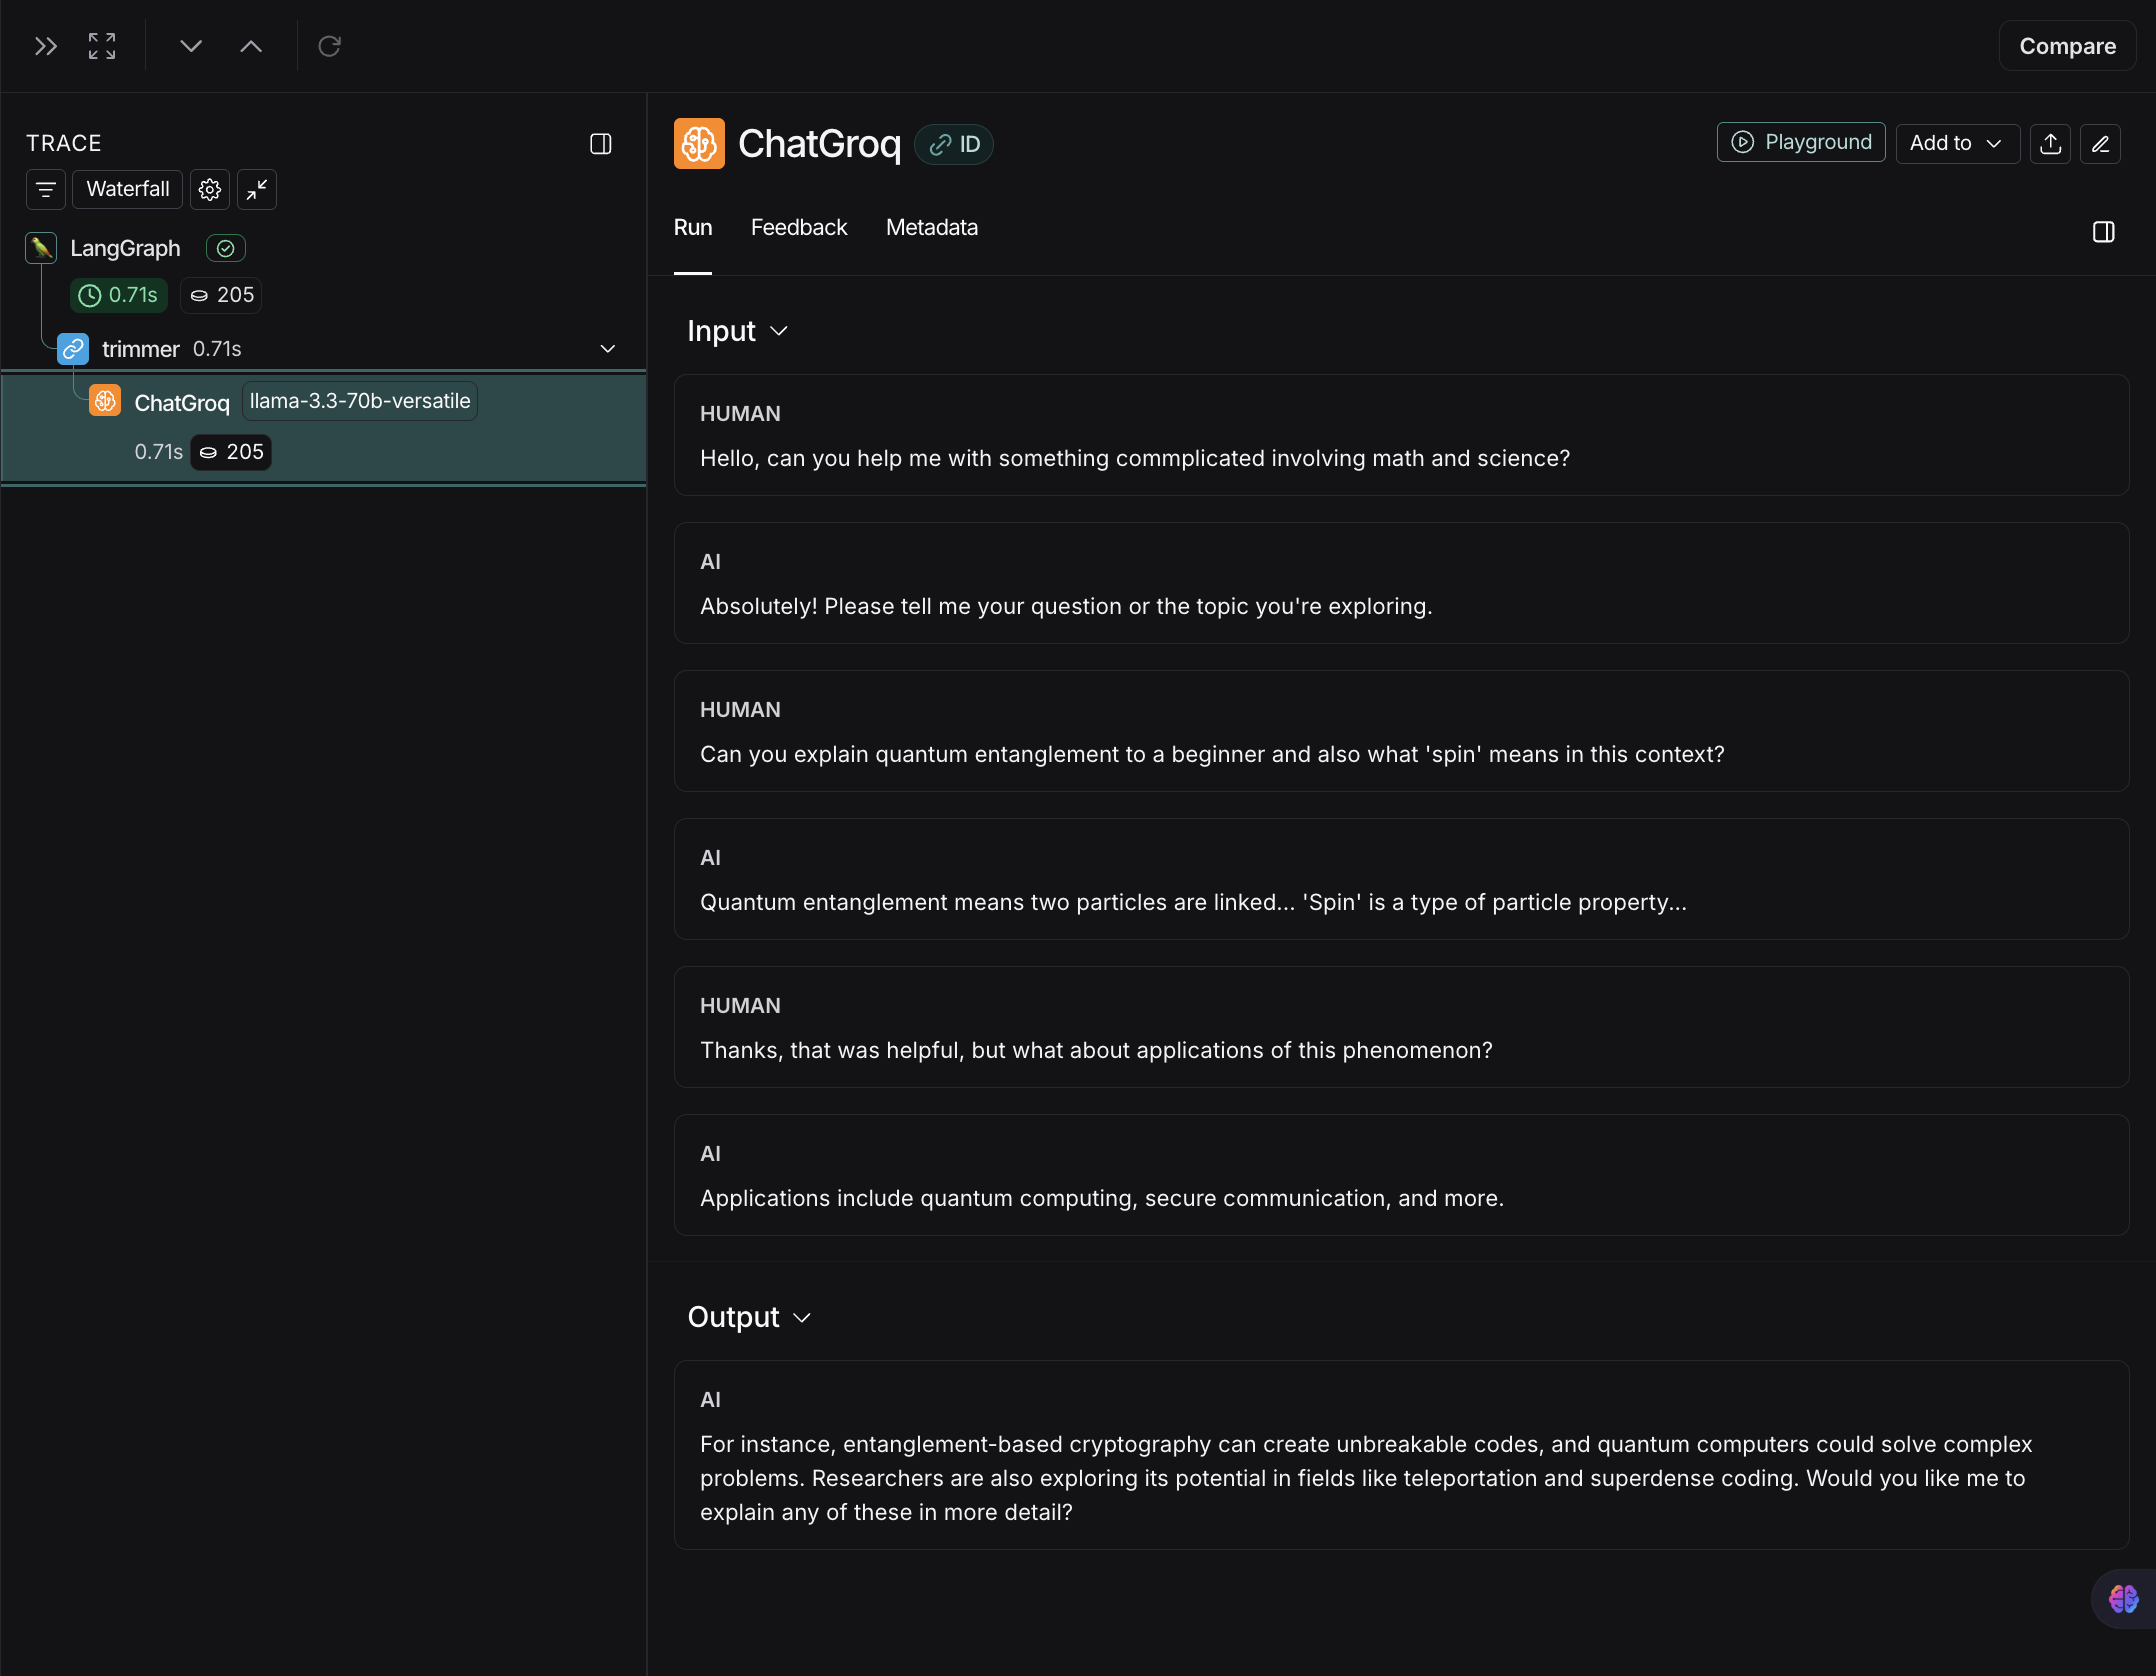

### screenshot from langsmith portal